In [2]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
# datascience version number of last run of this notebook
version.__version__

'0.5.19'

<h1>Class 12: The minimum legal drinking age, mortality, and regression discontinuity</h1>


<img src="https://s-media-cache-ak0.pinimg.com/236x/67/69/94/676994d6db963da8583b06cd5592724d.jpg" align=right valign=top width=160> 

What is the effect of the minimum legal drinking age (MLDA) of 21 on outcomes?  

*Drinking is bad, m'kay?*

But on the other hand, maybe the MLDA isn't a binding constraint. Maybe young people find a way to obtain alcohol while underage, and maybe all the MLDA accomplishes is an unnecessary restriction of liberty.

It's more than a little challenging to figure this out, because drinking when underage, $X$, and other outcomes like reckless driving, $Y$, are probably both caused by a taste for risk-taking, $Z$.  The problem is that we usually don't observe $Z$, and thus if we try to model reckless driving as a function of underage drinking,

$$Y_i = \alpha + \beta X_i + \epsilon_i$$

then we are likely to find that our estimate $\hat{\beta}$ will be subject to *omitted variable bias* or worse, because taste for risk $Z$ is not measured.

Another way of phrasing this problem is that we know $Z$ varies systematically across control and treatment groups in this comparison.  In other words, the group that is "treated" by drinking likely has a higher taste for risk-taking than the "control group" that does not drink.

There are several statistical methods to approach this kind of problem, which is prevalent in social science.

One method that we haven't seen yet in L&S 88-1 is the method of **regression discontinuity**.

In this approach, the researcher looks for a relationship between a $y$ and an $x$ that (A) reveals a treatment above or below a threshold level of $x$, and (B) ought otherwise to be **smooth** except for this treatment. 

Here is an <a href="http://blogs.worldbank.org/impactevaluations/regression-discontinuity-porn"> example from a blog page at the World Bank</a>. As the blog states, the example is drawn from "Mbiti & Lucas (2013) [who] test the impact of secondary school quality on student achievement in Kenya, using the cut-off on the primary exit exam required to get into better secondary schools."  As you can see, passing the cutoff on the exam ($x$) produced a large discontinuous jump in the secondary school graduation rate ($y$).

<img src="http://blogs.worldbank.org/impactevaluations/files/impactevaluations/mbiti%20kenya%20rd.png
" align=center valign=top width=400> 

There are a number of ways in which this might appear, but the critical thing is looking for a *discontinuous jump* at the treatment.

As we have done recently, let's use the very helpful <a href="http://statsmodels.sourceforge.net/">Statsmodels</a> 
module and some <a href="http://pandas.pydata.org/">Pandas</a> functions to run a multivariate regression. 

In [3]:
import statsmodels.api as sm
import pandas as pd

Here is the dataset, with a 0/1 indicator variable for being over 21 years of age (equal to or over 21). 

The age variable is a non-integer because of weightings of person-years at particular months of age. It is close to year plus month.  The other variables are the mortality rates per 100,000 for specific causes of death.  

All data are provided by Carpenter and Dobkin (*Journal of Economic Perspectives*, 2011).

In [4]:
Tabledrinkage = Table.read_table('http://demog.berkeley.edu/~redwards/Courses/LS88/c12_drinkage.csv')
Tabledrinkage

age,age21,over21,allmort,internal,external,alcohol,homicide,suicide,mva,drugs,otherexternal,ones
19.0685,-2,0,92.8254,16.6176,76.2078,0.751927,16.3168,11.2037,35.8293,3.75964,8.53437,1
19.1507,-1.917,0,95.1007,18.3277,76.7731,0.827945,16.86,12.1934,35.6393,3.08598,8.65579,1
19.2329,-1.833,0,92.1443,18.9111,73.2332,0.979457,15.2193,11.7158,34.2056,3.08906,8.51374,1
19.3151,-1.75,0,88.4278,16.1018,72.326,1.16898,16.7428,11.275,32.279,2.97902,8.25828,1
19.3973,-1.667,0,88.7049,17.3635,71.3414,1.17015,14.9477,10.9843,32.651,3.39721,8.41753,1
19.4795,-1.583,0,90.1918,17.8721,72.3197,1.32246,15.6428,12.1666,32.7214,3.06055,7.97255,1
19.5616,-1.5,0,96.2203,16.4149,79.8054,1.09685,16.2637,12.4058,36.3852,3.63096,10.2877,1
19.6438,-1.417,0,89.6156,15.9771,73.6385,1.28725,15.8256,10.9795,34.1879,3.29385,8.67003,1
19.726,-1.333,0,93.3817,17.4333,75.9484,1.32644,16.789,11.9001,31.9105,3.90354,10.7632,1
19.8082,-1.25,0,90.858,18.2854,72.5726,0.986349,16.6162,11.5706,30.5768,3.5281,9.86349,1


<h2>Setup</h2>

Mortality rates typically rise with age, although they may also be flat or declining with age over certain age ranges.  Generally, one might want to fit the *log* of the mortality rate to age, at least at older ages when mortality tends to rise exponentially.  At young ages, however, mortality rates tend to be either constant, falling, or only gently rising, so modeling the mortality rate *m* as a linear function of age *a* is probably just fine.

The easiest way to model a regression discontinuity is by specifying a jump in the $y$-intercept in a linear regression equation.  Here is what that would look like in a linear model of the mortality rate $m$ by age $a$:

$$ m_i = \alpha + \beta \ a_i + \gamma \ over21_i + \epsilon_i
$$

where $over21_i$ is an indicator variable of being over 21 years old, our treatment threshold.  Thus $\gamma$ adds to the constant term $\alpha$ for the treated people aged 21 and older, while the slope $\beta$ remains unchanged between treatment and control.

Now let's run OLS after we switch data types:

In [5]:
drinkage = Tabledrinkage.to_df()
type(drinkage)

pandas.core.frame.DataFrame

Let's first examine how all mortality (`allmort`) may or may not jump discretely at age 21. 

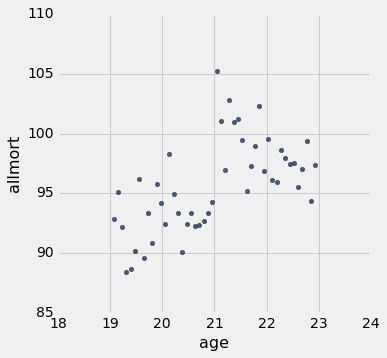

In [6]:
Tabledrinkage.scatter('age','allmort')

<font color="blue">Does your eye see a discontinuous jump at 21 in this graph?</font>

Now let's run OLS with our $over21$ dummy variable, and let's see whether it's statistically significant.  If it is, then there's a discontinuity.

In [7]:
x = drinkage[['ones','age','over21']]
y = drinkage['allmort']
#multiple_regress = sm.OLS(y, x).fit()
#multiple_regress.summary()

<font color="blue">What did you find? What does it mean?</font>

Now let's examine internal-cause mortality.

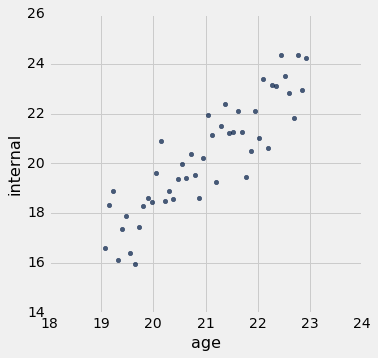

In [20]:
Tabledrinkage.scatter('age','internal')

<font color="blue">Does your eye see a discontinuous jump at 21 in this graph?</font>

As before, let's run OLS with the dummy variable and see what we find.

In [8]:
#x = drinkage[['ones','age','over21']]
#y = ...
#multiple_regress = sm.OLS(y, x).fit()
#multiple_regress.summary()

<font color="blue">Comment on what you see. Does this make sense? Does it contradict your earlier findings?</font>

Finally, let's look at motor vehicle accidents.

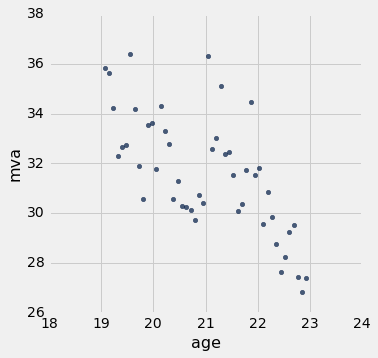

In [23]:
Tabledrinkage.scatter('age','mva')

<font color="blue">Does your eye see a discontinuous jump at 21 in this graph?</font>

In [9]:
#x = drinkage[['ones','age','over21']]
#y = ...
#multiple_regress = sm.OLS(y, x).fit()
#multiple_regress.summary()

<font color="blue">Comment on what you see. Does this make sense? Does it contradict your earlier findings?</font>